# Approximate MPC with CSTR

In this Jupyter Notebook, we illustrate the example **Approximate MPC with CSTR**.

This example is an extension of the CSTR example and consists of three modules: **template_model.py**, which describes the system model; **template_mpc.py**, which defines the settings for the controller we want to approximate; and **template_simulator.py**, which sets the parameters for the simulator. In the **main.py** file, we introduce the concept of approximate MPC by generating training data, training on that data, and finally performing a closed-loop evaluation.

In the following sections, each part is presented. We begin by importing basic modules and **do-mpc**.

In [1]:
import torch
from casadi.tools import *
import sys
import os

# Add do_mpc to path. This is not necessary if it was installed via pip
rel_do_mpc_path = os.path.join('..', '..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc


import matplotlib.pyplot as plt

C:\Users\smjsadam\Documents\Job\Forschung\Code\do-mpc_approx_mpc\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\smjsadam\Documents\Job\Forschung\Code\do-mpc_approx_mpc\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{K}}$):

In [3]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

The control inputs are the feed $F$ and the heat flow $\dot{Q}$:

In [4]:
# Input struct (optimization variables):
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= F \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= -F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + K_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}

where

\begin{align}
k_1 &= \beta \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_2 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-\alpha \cdot E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}

In [5]:
# Certain parameters
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # Universal gas constant
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.01 #0.01 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
T_in = 130.0 # Temp of inflow [Celsius]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = (5.7+4.5)/2.0*1.0 # Concentration of A in input Upper bound 5.7 lower bound 4.5 [mol/l]
alpha=1
beta=1


In the next step, we formulate the $k_i$-s:

In [6]:
# Auxiliary terms
K_1 = beta * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-alpha*E_A_ad)/((T_R+273.15)))

Additionally, we define an artificial variable of interest, that is not a state of the system, but will be later used for plotting:

In [7]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

With the help of the $k_i$-s and $T_{\text{dif}}$ we can define the ODEs:

In [8]:
model.set_rhs('C_a', F*(C_A0 - C_a) -K_1*C_a - K_3*(C_a**2))
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*Cp)) + F*(T_in-T_R) +(((K_w*A_R)*(-T_dif))/(Rou*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

Finally, the model setup is complete:

In [9]:
# Build the model
model.setup()

## Controller

Next, the model predictive controller is configured. This is needed as the approximate MPC is a supervised training approach, where the training data is generated by the MPC. Therefore, the MPC and the model specifies the behavior of the approximate MPC.
First, one member of the mpc class is generated with the prediction model defined above:

In [10]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon`, set the robust horizon `n_robust` to 0.
It is possible to use the approximate MPC for robust MPC, but in its current only open-loop sampling can be used as a sampling strategy for the robust MPC.
The time step `t_step` is set to 0.005h and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [11]:
# Set settings of MPC:
mpc.settings.n_horizon = 20
mpc.settings.n_robust = 0
mpc.settings.open_loop = 0
mpc.settings.t_step = 0.005
mpc.settings.state_discretization = 'collocation'
mpc.settings.collocation_type = 'radau'
mpc.settings.collocation_deg = 2
mpc.settings.collocation_ni = 1
mpc.settings.store_full_solution = True

Because the magnitude of the states and inputs is very different, we introduce scaling factors:

In [12]:
mpc.scaling['_x', 'T_R'] = 100
mpc.scaling['_x', 'T_K'] = 100
mpc.scaling['_u', 'Q_dot'] = 2000
mpc.scaling['_u', 'F'] = 100

### Objective

The goal of the CSTR is to obtain a mixture with a concentration of $C_{\text{B,ref}} = 0.6$ mol/l.
Additionally, we add a penalty on input changes for both control inputs, to obtain a smooth control performance.

In [13]:
mterm = (model.x['C_b'] - 0.6)**2+(model.x['C_a'] - 0.7)**2
lterm = (model.x['C_b'] - 0.6)**2+(model.x['C_a'] - 0.7)**2

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(F=0.1, Q_dot = 1e-3)

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input:

In [14]:
# lower bounds of the states
mpc.bounds['lower', '_x', 'C_a'] = 0.1
mpc.bounds['lower', '_x', 'C_b'] = 0.1
mpc.bounds['lower', '_x', 'T_R'] = 50
mpc.bounds['lower', '_x', 'T_K'] = 50

# upper bounds of the states
mpc.bounds['upper', '_x', 'C_a'] = 2
mpc.bounds['upper', '_x', 'C_b'] = 2
mpc.bounds['upper', '_x', 'T_R'] = 140
mpc.bounds['upper', '_x', 'T_K'] = 140

# lower bounds of the inputs
mpc.bounds['lower', '_u', 'F'] = 5
mpc.bounds['lower', '_u', 'Q_dot'] = -8500

# upper bounds of the inputs
mpc.bounds['upper', '_u', 'F'] = 100
mpc.bounds['upper', '_u', 'Q_dot'] = 0.0

The setup of the MPC controller is concluded by:

In [15]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [16]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator to run the approximate MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [17]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [18]:
params_simulator = {
        'integration_tool': 'cvodes',
        'abstol': 1e-10,
        'reltol': 1e-10,
        't_step': 0.005
    }

simulator.set_param(**params_simulator)

To finish the configuration of the simulator, call:

In [19]:
simulator.setup()

## Initialization of the MPC and Simulator

For the initialization of the MPC configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [20]:
# Set the initial state of mpc and simulator:
C_a_0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b_0 = 0.5 # This is the controlled variable [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]
x0 = np.array([C_a_0, C_b_0, T_R_0, T_K_0]).reshape(-1,1)
u0=np.array([[5],[0]])

# pushing to class
mpc.u0=u0
mpc.x0 = x0
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

## Approximate MPC

So far, we have only initialized our model, the MPC and the Simulator, which is like the usage of a MPC for controlling the system. In the next steps we must configure our approximate MPC, the Sampler for generating training data and the Trainer for training the Approximate MPC.
These three classes are the main components of the Approximate MPC. As it is standard in do-mpc, each of these classes can be configured using the settings of the respective class. After calling **setup()** the instance of the class is ready to be used.
First, the Approximate MPC is configured. One member of the ApproximateMPC class is generated which is initialized with the MPC class defined above:

In [53]:
approx_mpc = do_mpc.approximateMPC.ApproxMPC(mpc)

Appropriate sizes for number of hidden layers `n_hidden_layers` and number of neurons per layer `n_neurons` are chosen in this example using the settings class. Note that default parameters of each settings parameter are provided.:

In [54]:
approx_mpc.settings.n_hidden_layers = 1
approx_mpc.settings.n_neurons = 50

Other setting parameters for the approximate MPC include the activation function and the device on which the approximate MPC should run. The setup of the Approximate MPC controller is concluded by:

In [55]:
approx_mpc.setup()

----------------------------------
ApproxMPC(
  (net): FeedforwardNN(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)
----------------------------------


C:\Users\smjsadam\Documents\Job\Forschung\Code\do-mpc_approx_mpc\venv\lib\site-packages\torch\utils\_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Sampler

Next, a Sampler is configured. This class is used to generate training data for Approximate MPC.
It uses the already established sampling planner of do-mpc, son in case you want to take a deep dive into generating data with do-mpc, you can revisit the respective example. This class also needs to be initialized with the MPC class as it uses the MPC to generate the training data.

In [37]:
sampler = do_mpc.approximateMPC.AMPCSampler(mpc)

Next, the Sampler settings are configured. Currently, we support two sampling approaches, the open-loop standard sampling, where **n_samples** random data is sampled within the bounds of the MPC. The `closed_loop_flag` can be used to use a closed-loop sampling approach where closed loop trajectories of the length **trajectory_length**. Note that now **n_samples*trajectory_length** sampling data points are generated. In fact, in this example we do open loop sampling by setting `trajectory_length=1` but are showing how to use the closed loop sampling method in general. Again, these parameters are set through the settings class.

In [38]:
sampler.settings.closed_loop_flag = True
sampler.settings.trajectory_length = 1
sampler.settings.n_samples = 10000

The number of samples is a mandatory setting. The other one is the name of the dataset. You can also set the directory in which this dataset is stored which is optional

In [39]:
data_dir= './sampling_notebook'
sampler.settings.data = data_dir
dataset_name = "my_dataset"
sampler.settings.dataset_name = dataset_name

The setup of the Sampler class is concluded by:

In [40]:
sampler.setup()

The Sampler is now used to generate the sample data on which the ApproximateMPC will be trained further. for this a default sampling plan is used. This iteratively calculates the training data, so depending on `n_samples` and the complexity of the MPC controller, it might take a while. (The output of the MPC is suppressed with the magic command `%%capture`) For this example we have already generated the data

In [41]:
%%capture
#sampler.default_sampling()

## Trainer

Next, a Trainer is configured. The Trainer is used to train the approximate MPC on the generated training data. Therefore, the Trainer is initialized with the ApproximateMPC class:

In [56]:
trainer = do_mpc.approximateMPC.Trainer(approx_mpc)

Next the trainer setting parameters are configured. Make sure to set the right direction for the training data, which is done by setting the `data_dir` and the right name of the dataset.:

In [57]:
trainer.settings.data_dir = data_dir
trainer.settings.dataset_name = dataset_name

We now set the hyper-parameters for the training of the approximate MPC such as `n_epochs`. The Trainer also can use the learning rate scheduler of Pytorch for which the parameters can be set with the `scheduler_settings`. This can improve the training performance when hitting a plateau, by reducing the learning rate, so that the loss does not oscillate around the optimal point.

In [58]:
trainer.settings.n_epochs = 1000
trainer.settings.scheduler_flag = True
trainer.scheduler_settings.cooldown = 0
trainer.scheduler_settings.patience = 50

To display and save the performance of the training, the following flags may be set:

In [59]:
trainer.settings.show_fig =True
trainer.settings.save_fig = True
trainer.settings.save_history = True

The location where the samples data is stored is provided with `results_dir`:

In [60]:
trainer.settings.results_dir = './training_notebook'

Finally, the trainer is setup:

In [61]:
trainer.setup()

The training process is initiated:

Path from trainer to sampled files
 sampling_notebook\my_dataset\data_my_dataset_opt.pkl
epoch :  9
train_loss :  0.007376601065819462
val_loss :  0.007226864108815789
-------------------------------
epoch :  19
train_loss :  0.004398096740866701
val_loss :  0.0044473588932305574
-------------------------------
epoch :  29
train_loss :  0.004287740060438712
val_loss :  0.004649014212191105
-------------------------------
epoch :  39
train_loss :  0.004270521691069007
val_loss :  0.005127501906827092
-------------------------------
epoch :  49
train_loss :  0.004271700396202505
val_loss :  0.004730510525405407
-------------------------------
epoch :  59
train_loss :  0.004304454390270014
val_loss :  0.004495328990742564
-------------------------------
epoch :  69
train_loss :  0.0041738704312592745
val_loss :  0.004619996529072523
-------------------------------
epoch :  79
train_loss :  0.004146106114300589
val_loss :  0.0041077801724895835
-------------------------------
epoch :  89
t

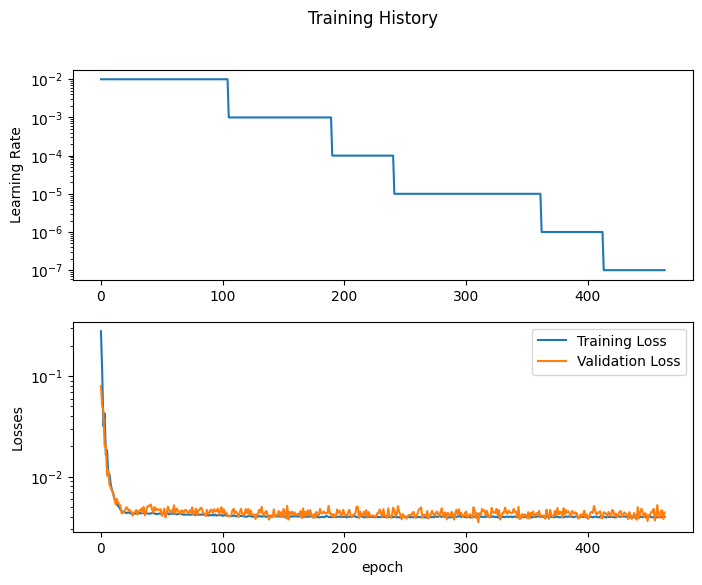

In [62]:
torch.manual_seed(42)
trainer.default_training()

# Closed loop simulation

Now all we are ready for simulating the system with the newly trained approximate MPC controller, for 50 steps. As for the MPC the `make_step` function of the approximate MPC is used where instead of solving an optimization problem the pre-trained neural network is evaluated. It is possible to clip the control inputs to the bounds of the MPC controller with the flag `clip_to_bounds=True`.

When `clip_to_bounds=True`, the inputs are forced to be within the set upper boundary and the set lower boundary, ensuring that no matter what, the inputs are within permissible bounds.

In [63]:
sim_time = 100
approx_mpc.u0=u0
for k in range(sim_time):
    u0 = approx_mpc.make_step(x0, clip_to_bounds=True)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

## Visualization

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

Here we use `simulator.data`, since the simulator consists of the class which stores the data which can be extracted. As a contrast, the data from the mpc class cannot be used, since in the main simulation loop, mpc class is not used.

In [64]:
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

We then create a figure, configure which lines to plot on which axis and add labels.

Text(0.5, 0, 'time [h]')

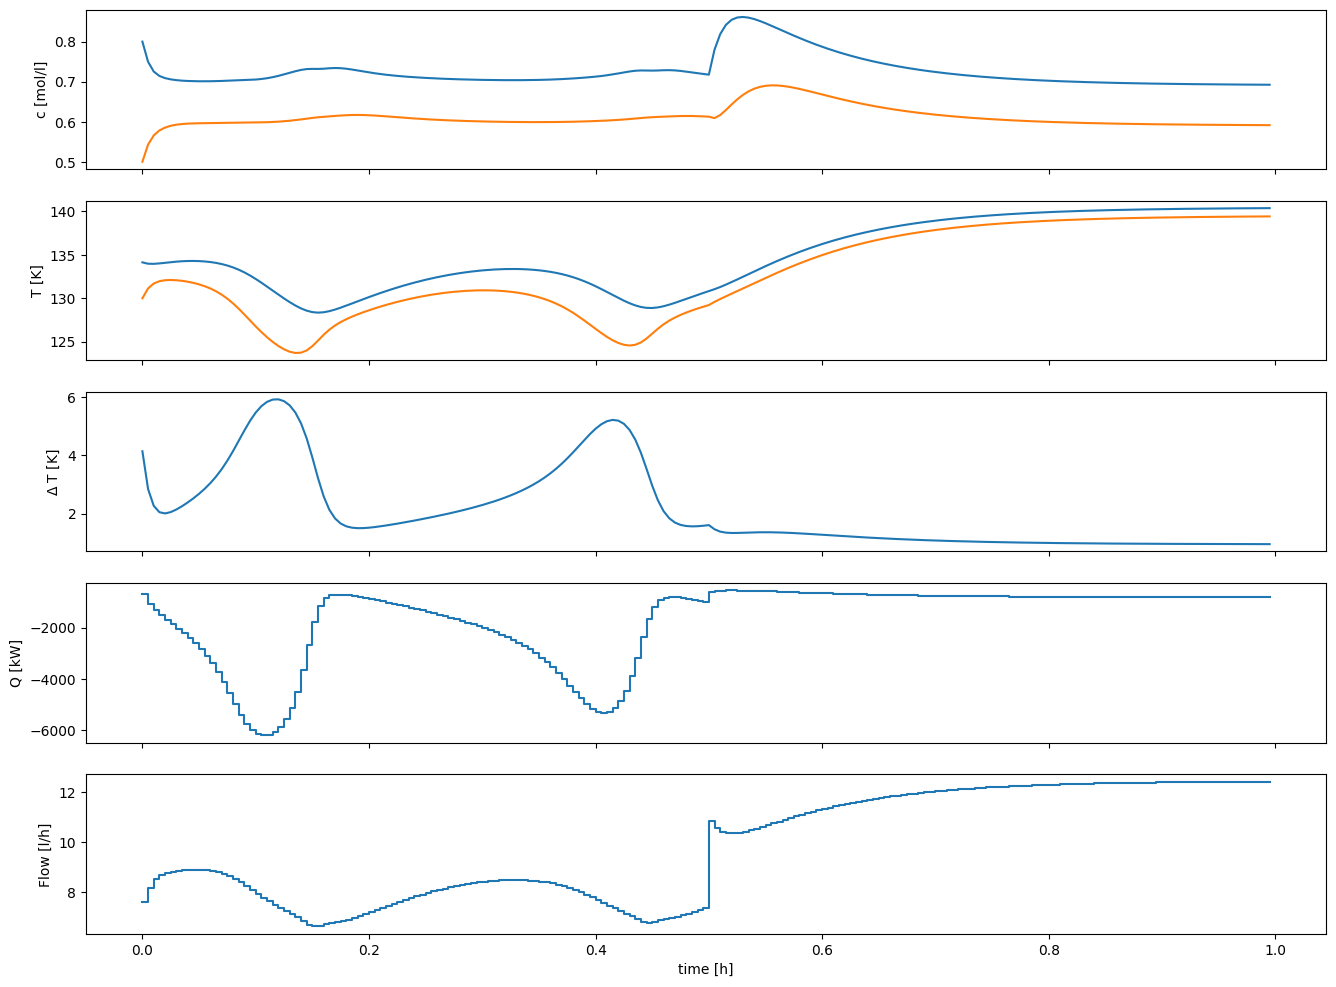

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
# Configure plot:
sim_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[1])
sim_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[1])
sim_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[2])
sim_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[3])
sim_graphics.add_line(var_type='_u', var_name='F', axis=ax[4])
ax[0].set_ylabel('c [mol/l]')
ax[1].set_ylabel('T [K]')
ax[2].set_ylabel('$\Delta$ T [K]')
ax[3].set_ylabel('Q [kW]')
ax[4].set_ylabel('Flow [l/h]')
ax[4].set_xlabel('time [h]')

Some "cosmetic" modifications are easily achieved with the structure `result_lines`.

In [66]:
# Add labels
label_lines = sim_graphics.result_lines['_x', 'C_a']+sim_graphics.result_lines['_x', 'C_b']
ax[0].legend(label_lines, ['C_a', 'C_b'])
label_lines = sim_graphics.result_lines['_x', 'T_R']+sim_graphics.result_lines['_x', 'T_K']
ax[1].legend(label_lines, ['T_R', 'T_K'])

from matplotlib.animation import FuncAnimation, ImageMagickWriter
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    sim_graphics.plot_results(t_ind=t_ind)
    sim_graphics.plot_predictions(t_ind=t_ind)
    sim_graphics.reset_axes()
    lines = sim_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]

fig.align_ylabels()
anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('anim_CSTR.gif', writer=gif_writer)

C:\Users\smjsadam\Documents\Job\Forschung\Code\do-mpc_approx_mpc\venv\lib\site-packages\matplotlib\animation.py:1725: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(
C:\Users\smjsadam\Documents\Job\Forschung\Code\do-mpc_approx_mpc\venv\lib\site-packages\matplotlib\animation.py:1725: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(
MovieWriter stderr:
magick.exe: unexpected end-of-file '-': No such file or directory @ error/rgb.c/ReadRGBImage/249.



CalledProcessError: Command '['C:\\Program Files\\ImageMagick-7.1.1-Q16-HDRI\\magick.exe', '-size', '1600x1200', '-depth', '8', '-delay', '20.0', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'anim_CSTR.gif']' returned non-zero exit status 1.

![cstranim](anim_appxCSTR_nb.gif "cstr")